<a href="https://colab.research.google.com/github/Munchlax-byte/CS4774/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [ ]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

housing = pd.read_csv("https://raw.githubusercontent.com/Munchlax-byte/CS4774/main/housing.csv")
X_train, X_test = train_test_split(housing, test_size=0.2, random_state=42) # data
y_train, y_test = train_test_split(housing["median_house_value"], test_size=0.2, random_state=42) # label as in actual values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


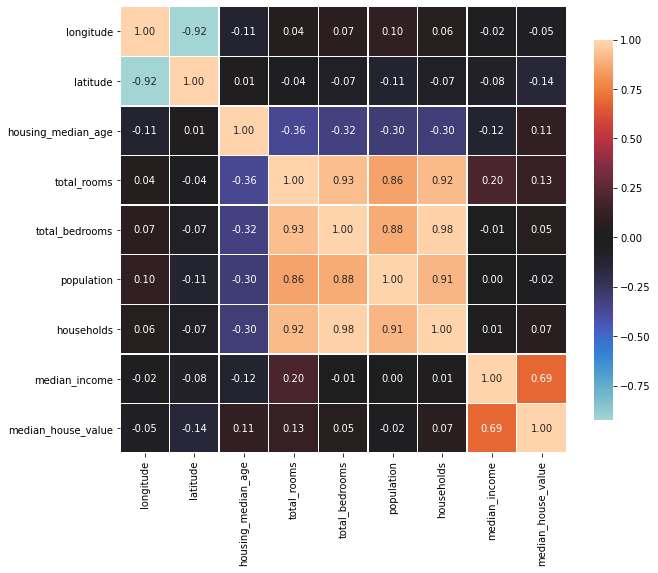

In [ ]:
'''
@source https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
'''
import seaborn as sns
import matplotlib.pyplot as plt


train = housing

def correlation_heatmap(train=housing):
    '''
    ' finding correlation in relation to MEDV
    '''
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(train)

In [ ]:
from sklearn.preprocessing import OneHotEncoder # Label encoding
from sklearn.compose import ColumnTransformer # Pipelining data

import numpy as np # Data type

housingx = X_train.drop("median_house_value", axis=1)
housing_numx = housingx.drop(["ocean_proximity"], axis=1)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())                     
])

num_attribs = np.array(housingx)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", pipeline, num_attribs),                
    ("cat", OneHotEncoder(), cat_attribs)
])

X_train = pipeline.fit_transform(housing_numx)

In [ ]:
X_train.shape[0] # Shape of training Data

16512

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
import random

def randomK(low, high):
  '''
  randomly select a k between low and high
  @param low value
  @param high value
  @return random integer between low and igh
  '''
  if low > high:
    print("Invalid input! \n Returning default randomK")
    return randomK()
  return random.randint(low, high)

def randomK():
  '''
  randomly select a k between 1 and 7
  @return random integer between 1 and 7
  '''
  return random.randint(1, 7)

def KMeans(dataset, k, tol):
  '''
   Decide class membership of the m objects by
   assigning them to the nearest cluster centroid
  '''

  '''
  Step 2:
  initializing k cluster centers randomly
  '''
  centroids = {} # centroid stores the mean of clusters
  for i in range(k): # goes to k - 1
    centroids[i] = np.array(dataset[i])
  '''
  Step 3:
  Decide the class memberships of the m objects by assigning them to
  the nearest cluster centroid
  '''
  best = True
  while best:
    cluster = {}
    for i in range(k):
      cluster[i] = np.array([])

    for m in dataset:
      distance = [np.linalg.norm(m - centroids[centroid]) 
                    for centroid in centroids] # finding the distance between both centroids and appending it to a list
      label = distance.index(min(distance)) # index of the minimum distance corresponds to one of the saved centroids
      cluster[label] = np.append(cluster[label], np.array(m)) # row of data into appropriate cluster

    for i in range(k):
      cluster[i] = np.reshape(cluster[i], (-1, dataset.shape[1])) # reshaping clusters to dataset size

    prev_centroids = dict(centroids) # saving previous centroid before re-estimating k

    '''
    Step 4:
    Re-estimate the k cluster centroid, by assuming
    the membership found in step 3 are correct.

    '''
    for label in cluster: # my clusters an array of 2D arrays
      centroids[label] = np.mean(cluster[label], axis=0) # mean of cluster row i

    '''
    Step 5:
    if none of the m objects change membership, exit,
    otherwise repeat till no change
    '''
    for row in centroids: 
      '''
      finding if any m objects have changed membership
      by checking sum of centroids, otherwise I should check the percentages of centroids
      '''
      dif = np.sum(centroids[row] - prev_centroids[row]) # value to determing if m objects have changed membership

      if abs(dif) > tol: # checking if difference is greater than tolerance, will accept a minute change in membership
        break
      else:
        best = False

  return centroids, cluster # returns centroids, mean of cluster; cluster, data of cluster

In [ ]:
k = 2 # parameterizing k, k = number of clusters and centroids
centroids, cluster = KMeans(X_train, k, 0.0000001)
print(centroids) # showcasing means of clusters
print(cluster) # showcasing data associated with clusters

{0: array([ 0.77524008, -0.78838356, -0.02258727,  0.06937944,  0.09701237,
        0.1273344 ,  0.09639863,  0.03047681]), 1: array([-1.05631868,  1.07422759,  0.03077672, -0.09453432, -0.13218612,
       -0.173502  , -0.13134985, -0.04152678])}
{0: array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.76827628,
         0.32290591, -0.326196  ],
       [ 0.70916212, -0.87669601,  1.61811813, ..., -0.09890135,
         0.6720272 , -0.03584338],
       [-0.44760309, -0.46014647, -1.95271028, ..., -0.44981806,
        -0.43046109,  0.14470145],
       ...,
       [ 0.80888326, -0.87201568,  0.50719373, ..., -0.67584712,
        -0.74283277,  1.30721476],
       [ 1.07314428, -0.75968772,  0.34849025, ...,  0.28719498,
        -0.13383924, -0.43626638],
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.28983345,
         0.07090859, -0.49697313]]), 1: array([[-0.10855122,  0.5320839 ,  1.14200767, ..., -0.48587717,
        -0.31496232, -0.17148831],
       [-1.13567896,  0.83162514


- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


# Note from Leo:
I added a tolerance value to my KMeans to avoid an overly long recursion, but based on  my testing thus far, KMeans stops when no m objects have been moved.

In [ ]:
cluster[0].shape, cluster[1].shape

((9523, 8), (6989, 8))

In [ ]:
X_train.shape[1] # testing to find out how to reshape clusters array

8

# Sum squared error function:
Sum of squared error between points in a cluster and their respective centroid. The formula is calculating the squared distance between every single row in the cluster and their centroid, then summing all of this up to come up with the error.

In [ ]:
centroids

{0: array([ 0.77524008, -0.78838356, -0.02258727,  0.06937944,  0.09701237,
         0.1273344 ,  0.09639863,  0.03047681]),
 1: array([-1.05631868,  1.07422759,  0.03077672, -0.09453432, -0.13218612,
        -0.173502  , -0.13134985, -0.04152678])}

In [ ]:
def SSE(cluster, centroids):
  '''
  find the sum squared error the inputted cluster
  @param centeroid of the given cluster
  @param cluster
  @return sum of squared error
  '''
  sum = 0
  for row in cluster:
    sum += np.sum((row - centroids) ** 2)
  return sum

In [ ]:
print("Sum squared error of cluster one:", SSE(cluster[0], centroids[0]), 
      "\n" + "Sum squared error of cluster two:", SSE(cluster[1], centroids[1]))

Sum squared error of cluster one: 71143.7137933023 
Sum squared error of cluster two: 32520.242677009333


# Determining Lowest Sum of Squared Error Based on Clusters

In [ ]:
if SSE(cluster[0], centroids[0]) <= SSE(cluster[1], centroids[1]):
  print("Lowest SSE:", SSE(cluster[0], centroids[0]))
else:
  print("Lowest SSE:", SSE(cluster[1], centroids[1]))

Lowest SSE: 32520.242677009333


# Mean of Clusters:
Taking the values stored in the centeroid of the respective cluster and getting the mean.

In [ ]:
clusterOneMean = centroids[0]
clusterTwoMean = centroids[1]
print("Mean of cluster one:", clusterOneMean, "\n" + "Mean of cluster two:", clusterTwoMean)

Mean of cluster one: [ 0.77524008 -0.78838356 -0.02258727  0.06937944  0.09701237  0.1273344
  0.09639863  0.03047681] 
Mean of cluster two: [-1.05631868  1.07422759  0.03077672 -0.09453432 -0.13218612 -0.173502
 -0.13134985 -0.04152678]


In [ ]:
clusterTwoSize = cluster[1].shape[0] * cluster[1].shape[1]

# Standard deviation of Clusters:
Finding the standard deviation of each cluster by  taking the absolute value of the cluster - the power of the cluster's mean. Afterwards, summing this up and dividing by the size of the cluster.

In [ ]:
from math import sqrt, pow

def standardDeviation(cluster, centroids):
  '''
  @param cluster
  @param mean of the inputted cluster
  @return std of the inputted cluster
  '''
  return sqrt(np.sum(abs(cluster - (centroids) ** 2)) / (
      cluster.shape[0] * cluster.shape[1]))

print("Standard deviation of cluster one:", standardDeviation(cluster[0], clusterOneMean), 
      "\n" + "Standard deviation of cluster two:", standardDeviation(cluster[1], clusterTwoMean))

Standard deviation of cluster one: 0.8662856053418152 
Standard deviation of cluster two: 0.8988273597033626


In [ ]:
def printALL(cluster, centroids):
  for i in range(k):
    print("Mean of cluster" + str(i + 1) + ":",centroids[i])
    print("Standard deviation of cluster" + str(i + 1) + ":",standardDeviation(cluster[i], centroids[i]))
    print("Sum squared error of cluster" + str(i + 1) + ":",SSE(cluster[i], centroids[i]))
    print("\n")

def printSTD(cluster, centroids):
  for i in range(k):
    print("Standard deviation of cluster" + str(i + 1) + ":",standardDeviation(cluster[i], centroids[i]))

def printSSE(cluster, centroids):
  for i in range(k):
    print("Sum squared error of cluster" + str(i + 1) + ":",SSE(cluster[i], centroids[i]))

def printMEAN(centroids):
  for i in range(k):
    print("Mean of cluster" + str(i + 1) + ":", centroids[i])

# Visualizing California Housing Prices

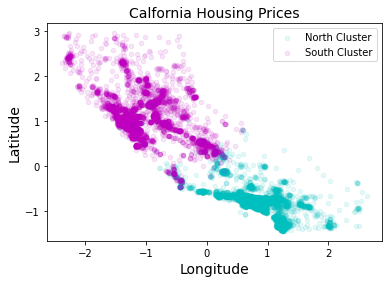

In [ ]:
# predict the labels of clusters.
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv'] # ignore this was testing

for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.1, s=20, cmap=cmaps['Cyclic'],
                label=["North Cluster", "South Cluster"][i],
                c=['c', 'm', 'g', 'b', ][i]) # low alpha shows weaker points
    # plt.scatter(centroids[i][:, 0] , centroids[i][:, 1] , s = 80, color = 'k')
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [ 0.77524008 -0.78838356 -0.02258727  0.06937944  0.09701237  0.1273344
  0.09639863  0.03047681]
Standard deviation of cluster1: 0.8662856053418152
Sum squared error of cluster1: 71143.7137933023


Mean of cluster2: [-1.05631868  1.07422759  0.03077672 -0.09453432 -0.13218612 -0.173502
 -0.13134985 -0.04152678]
Standard deviation of cluster2: 0.8988273597033626
Sum squared error of cluster2: 32520.242677009333




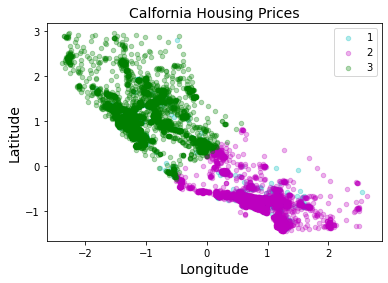

In [ ]:
k = 3 # plot periodic values
centroids, cluster = KMeans(X_train, k, 0.0001) # lowered tolerance to complete this quicker

for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.3, s=20, cmap=cmaps['Cyclic'],
                label=["1", "2", "3", "4", "5",
                       "6", "7", "8", "9", "10"][i],
                c=['c', 'm', 'g', 'b', "y", 
                   "#A45442", "k", "r", "#A4429D", "#A44256"][i]) # low alpha shows weaker points
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [ 0.19600535 -0.16495753 -0.94934649  2.34030957  2.41134966  2.21066866
  2.40181365  0.18044128]
Standard deviation of cluster1: 1.4919265801536183
Sum squared error of cluster1: 19950.580124548756


Mean of cluster2: [ 0.77600755 -0.79364197  0.08878192 -0.22285108 -0.20561214 -0.1467503
 -0.20087055  0.00846121]
Standard deviation of cluster2: 0.8042438764462541
Sum squared error of cluster2: 27978.597963189353


Mean of cluster3: [-1.07037426  1.08714465  0.08429347 -0.20251246 -0.24047878 -0.275809
 -0.24473533 -0.04960673]
Standard deviation of cluster3: 0.8859369444139849
Sum squared error of cluster3: 23658.750353908745




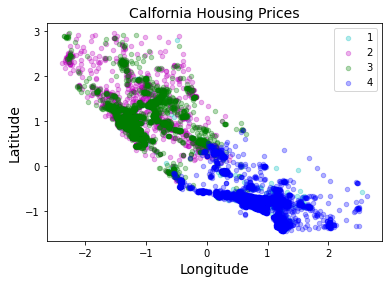

In [ ]:
k = 4 # plot periodic values
centroids, cluster = KMeans(X_train, k, 0.0001) # lowered tolerance to complete this quicker

for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.3, s=20, cmap=cmaps['Cyclic'],
                label=["1", "2", "3", "4", "5",
                       "6", "7", "8", "9", "10"][i],
                c=['c', 'm', 'g', 'b', "y", 
                   "#A45442", "k", "r", "#A4429D", "#A44256"][i]) # low alpha shows weaker points
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [ 0.33400323 -0.29014967 -0.98794877  2.60644114  2.69630032  2.47816238
  2.67915574  0.1599803 ]
Standard deviation of cluster1: 1.6568046882515854
Sum squared error of cluster1: 17014.572629663253


Mean of cluster2: [-1.10285082  1.09928943  0.66708064 -0.47699987 -0.48873087 -0.52115528
 -0.49750365 -0.26255808]
Standard deviation of cluster2: 0.9507526140135095
Sum squared error of cluster2: 9780.543189962615


Mean of cluster3: [-0.95964526  0.99236933 -0.75106839  0.2639413   0.18377066  0.14256242
  0.18958595  0.23860843]
Standard deviation of cluster3: 0.8821047613578279
Sum squared error of cluster3: 10472.009769815237


Mean of cluster4: [ 0.7921028  -0.80781763  0.09647766 -0.21650503 -0.19427679 -0.13698787
 -0.19021547  0.01182383]
Standard deviation of cluster4: 0.8067253869499472
Sum squared error of cluster4: 27975.603789427565




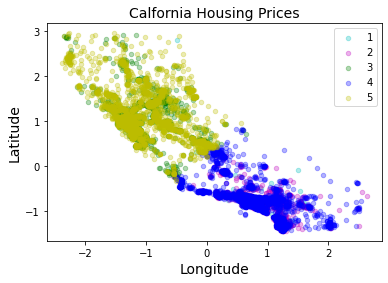

In [ ]:
k = 5 # plot periodic values
centroids, cluster = KMeans(X_train, k, 0.0001) # lowered tolerance to complete this quicker

for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.3, s=20, cmap=cmaps['Cyclic'],
                label=["1", "2", "3", "4", "5",
                       "6", "7", "8", "9", "10"][i],
                c=['c', 'm', 'g', 'b', "y", 
                   "#A45442", "k", "r", "#A4429D", "#A44256"][i]) # low alpha shows weaker points
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [ 0.26719893 -0.19709506 -1.15315716  4.00855443  3.97886656  3.7504141
  3.95205024  0.27392481]
Standard deviation of cluster1: 2.52502744483984
Sum squared error of cluster1: 9144.693625742768


Mean of cluster2: [ 0.83798082 -0.82507465 -0.59653695  0.68489219  0.79688516  0.76689568
  0.78797895  0.09811433]
Standard deviation of cluster2: 0.8362784375573687
Sum squared error of cluster2: 8876.531602492689


Mean of cluster3: [-1.02166475  1.01955133 -0.723098    0.5861809   0.53558725  0.45438696
  0.55513136  0.16254442]
Standard deviation of cluster3: 0.8913002823618994
Sum squared error of cluster3: 7644.411002465838


Mean of cluster4: [ 0.76220392 -0.7842006   0.27101539 -0.41449662 -0.4155133  -0.34388698
 -0.40904595 -0.01665181]
Standard deviation of cluster4: 0.8306478007797136
Sum squared error of cluster4: 17271.21539701688


Mean of cluster5: [-1.08609068  1.10497525  0.38914714 -0.43995392 -0.47206166 -0.49802136
 -0.48328167 -0.13301524]
Standard d

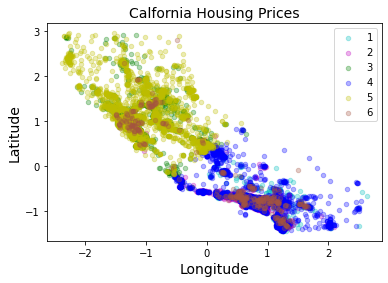

In [ ]:
k = 6 # plot periodic values
centroids, cluster = KMeans(X_train, k, 0.0001) # lowered tolerance to complete this quicker

for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.3, s=20, cmap=cmaps['Cyclic'],
                label=["1", "2", "3", "4", "5",
                       "6", "7", "8", "9", "10"][i],
                c=['c', 'm', 'g', 'b', "y", 
                   "#A45442", "k", "r", "#A4429D", "#A44256"][i]) # low alpha shows weaker points
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [ 0.84513902 -0.8173411  -0.61921012  0.79896655  0.99839487  0.9311328
  0.97672439 -0.1151123 ]
Standard deviation of cluster1: 0.8386390595911712
Sum squared error of cluster1: 6688.128326449825


Mean of cluster2: [ 0.56222713 -0.64721676 -0.3704807  -0.09830359 -0.39113825 -0.33572852
 -0.37009962  1.68046325]
Standard deviation of cluster2: 0.8807370954204016
Sum squared error of cluster2: 7005.600516980378


Mean of cluster3: [-1.04115462  1.02561571 -0.70415343  0.67767361  0.63986859  0.53882198
  0.66272167  0.1188358 ]
Standard deviation of cluster3: 0.8891770830708753
Sum squared error of cluster3: 6669.565999940943


Mean of cluster4: [ 0.76237423 -0.7711646   0.38185693 -0.4338219  -0.37162519 -0.29361291
 -0.36813738 -0.38627632]
Standard deviation of cluster4: 0.8076563822929373
Sum squared error of cluster4: 10394.32045209041


Mean of cluster5: [-1.0872399   1.12097503  0.3570295  -0.42855017 -0.45446102 -0.48224787
 -0.46668423 -0.22186749]
Standard

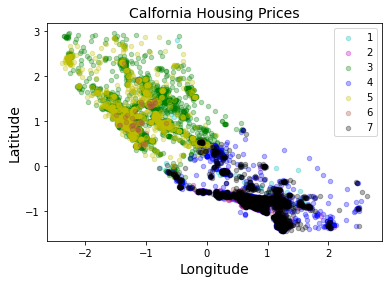

In [ ]:
k = 7 # plot periodic values
centroids, cluster = KMeans(X_train, k, 0.0001) # lowered tolerance to complete this quicker

for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.3, s=20, cmap=cmaps['Cyclic'],
                label=["1", "2", "3", "4", "5",
                       "6", "7", "8", "9", "10"][i],
                c=['c', 'm', 'g', 'b', "y", 
                   "#A45442", "k", "r", "#A4429D", "#A44256"][i]) # low alpha shows weaker points
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [ 0.05114572 -0.03767284 -0.89476053  1.98970262  2.10170179  1.87536508
  2.09862663  0.1470238 ]
Standard deviation of cluster1: 1.2522844910196238
Sum squared error of cluster1: 6453.0853294980125


Mean of cluster2: [ 0.43497537 -0.55196805 -0.24830867 -0.06644466 -0.41264716 -0.36223308
 -0.38939961  2.14230286]
Standard deviation of cluster2: 0.9621307304903317
Sum squared error of cluster2: 5527.094817662412


Mean of cluster3: [-0.97552728  1.09850648 -0.73260588  0.00163736 -0.05375544 -0.08938935
 -0.063408   -0.03026275]
Standard deviation of cluster3: 0.8685056320465944
Sum squared error of cluster3: 8792.808999667697


Mean of cluster4: [ 0.74584182 -0.76184876  0.49572982 -0.51320058 -0.48425979 -0.39571161
 -0.47822018 -0.31498158]
Standard deviation of cluster4: 0.8462228580871922
Sum squared error of cluster4: 8240.461520763869


Mean of cluster5: [-1.17663329  1.08847259  0.989611   -0.44115859 -0.44156057 -0.48227786
 -0.44123166 -0.27706473]
Standa

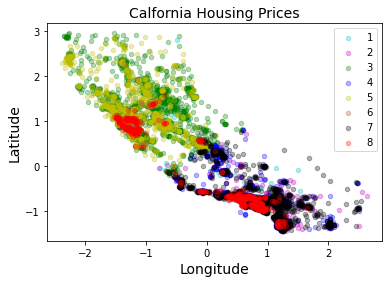

In [ ]:
k = 8 # plot periodic values
centroids, cluster = KMeans(X_train, k, 0.0001) # lowered tolerance to complete this quicker

for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.3, s=20, cmap=cmaps['Cyclic'],
                label=["1", "2", "3", "4", "5",
                       "6", "7", "8", "9", "10"][i],
                c=['c', 'm', 'g', 'b', "y", 
                   "#A45442", "k", "r", "#A4429D", "#A44256"][i]) # low alpha shows weaker points
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [-0.0350847   0.04466076 -0.92382468  2.12774515  2.21378736  1.97613038
  2.21908577  0.18778828]
Standard deviation of cluster1: 1.3274387011910929
Sum squared error of cluster1: 5822.994666627534


Mean of cluster2: [ 0.80147288 -0.79327199 -0.37697963  0.48761107  0.66963474  0.67753061
  0.66104302 -0.17838098]
Standard deviation of cluster2: 0.7639549364047938
Sum squared error of cluster2: 4911.995901798741


Mean of cluster3: [-0.98953401  1.12057141 -0.72864082  0.02777269 -0.01582354 -0.0570548
 -0.02600671 -0.06921011]
Standard deviation of cluster3: 0.8683018586973837
Sum squared error of cluster3: 8130.948414050325


Mean of cluster4: [ 0.71047101 -0.75256233  0.75644514 -0.47478164 -0.44020062 -0.34056081
 -0.42743898 -0.28906282]
Standard deviation of cluster4: 0.8046020238536846
Sum squared error of cluster4: 5994.34428881869


Mean of cluster5: [-1.16627929  1.09158143  0.95401544 -0.45353752 -0.45184117 -0.49123594
 -0.45322659 -0.31003014]
Standard 

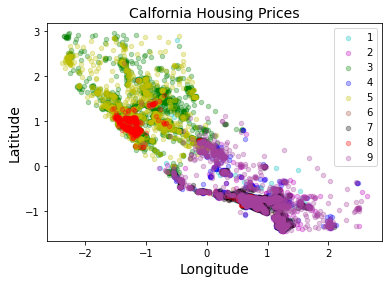

In [ ]:
k = 9 # plot periodic values
centroids, cluster = KMeans(X_train, k, 0.0001) # lowered tolerance to complete this quicker

for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.3, s=20, cmap=cmaps['Cyclic'],
                label=["1", "2", "3", "4", "5",
                       "6", "7", "8", "9", "10"][i],
                c=['c', 'm', 'g', 'b', "y", 
                   "#A45442", "k", "r", "#A4429D", "#A44256"][i]) # low alpha shows weaker points
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [-0.01118723  0.02684753 -0.94523443  2.19789284  2.26436352  2.02624803
  2.2691344   0.21274528]
Standard deviation of cluster1: 1.3634212691477345
Sum squared error of cluster1: 5563.46258610469


Mean of cluster2: [ 0.80946114 -0.79346291 -0.35179905  0.47288208  0.71932438  0.72327659
  0.70473704 -0.31249732]
Standard deviation of cluster2: 0.7625742460195967
Sum squared error of cluster2: 4224.667459659636


Mean of cluster3: [-1.01663145  1.12534068 -0.74032333  0.10397203  0.06202574  0.01273976
  0.05516057 -0.03705701]
Standard deviation of cluster3: 0.8718724441460531
Sum squared error of cluster3: 7228.101121553998


Mean of cluster4: [ 0.72143135 -0.77187579  0.85074413 -0.47440987 -0.44362149 -0.34022803
 -0.4286492  -0.26821886]
Standard deviation of cluster4: 0.8015508520546907
Sum squared error of cluster4: 4787.432110591065


Mean of cluster5: [-1.14751862  1.1076356   0.86446974 -0.46698553 -0.46183805 -0.49970267
 -0.4665666  -0.36458354]
Standard

In [ ]:
k = 10 # plot periodic values
centroids, cluster = KMeans(X_train, k, 0.0001) # lowered tolerance to complete this quicker

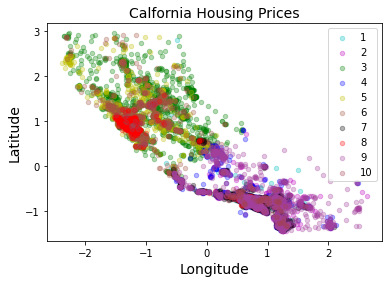

In [ ]:
for i in cluster:
    plt.scatter(cluster[i][:, 0] , cluster[i][:, 1],
                alpha=0.3, s=20, cmap=cmaps['Cyclic'],
                label=["1", "2", "3", "4", "5",
                       "6", "7", "8", "9", "10"][i],
                c=['c', 'm', 'g', 'b', "y", 
                   "#A45442", "k", "r", "#A4429D", "#A44256"][i]) # low alpha shows weaker points
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Calfornia Housing Prices", fontsize=14)
plt.legend()

plt.show()

In [ ]:
printALL(cluster, centroids)

Mean of cluster1: [ 0.22499438 -0.18662877 -1.00278204  2.54899915  2.641199    2.38063789
  2.62895023  0.22500555]
Standard deviation of cluster1: 1.5950644775025031
Sum squared error of cluster1: 3855.570703642484


Mean of cluster2: [ 0.82450929 -0.80751712 -0.39619883  0.59002971  0.8382774   0.83766088
  0.82796437 -0.25633457]
Standard deviation of cluster2: 0.7713521325091838
Sum squared error of cluster2: 4006.8896246148875


Mean of cluster3: [-0.9258058   1.17603288 -0.70872176 -0.38666155 -0.43997269 -0.46238356
 -0.47615375 -0.2079757 ]
Standard deviation of cluster3: 0.9159734190286266
Sum squared error of cluster3: 4339.125251740548


Mean of cluster4: [ 0.71081403 -0.75755995  0.84257506 -0.47602547 -0.44306588 -0.33566838
 -0.42848211 -0.28761236]
Standard deviation of cluster4: 0.8011925147771121
Sum squared error of cluster4: 5023.694725704522


Mean of cluster5: [-1.18764752  1.06833786  1.09673014 -0.4037196  -0.39913456 -0.43599044
 -0.39250956 -0.29911321]
Standa

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!

# Insight and Challenges
The California Housing Crisis seems to drive around the fact that there is a lot of beach front property available along the cost of California. Based on the clustering data, mainly data with 5 clusters, I can see that the density of housing is concentrated on the coast, but also that the rest of the housing prices trickle out from that focal point. The challenge is not letting the trickle effect impact houses miles away from the beach front property. Interestingly enough, the same issue is impacting my community in Annapolis. Annapolis is the capital of Maryland and along the coast. Thus, there is a range of houses priced over one million. Real estate agents are capitalizing on the higher end of range to sell houses away from the coast for more money. I believe this insight into my communtiy can be applied to California. Furthermore, the appeal of being a part of beach life in today's youth is overwhelming as everyone wants to be the instagram star flaunting their lifestyle in California.

P.S What do you call a cow with no legs?
Ground beef